In [95]:
import IMProToo
import xarray as xr
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta   
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from matplotlib.patches import Rectangle 

In [96]:
from matplotlib import dates

In [97]:
ds= xr.open_dataset('C:/Users/conym/Desktop/ing/semestre 7/proyecto de datos/0806_mrr2c.nc_1.nc')
#ds = xr.open_dataset('C:\Cony\Universidark\Proyecto de Datos 1\Datos\0806_mrr2c.nc_1.nc')

In [98]:

# Paletas de colores
paleta0 = ['#ccd8ff','#3366ff','#9fdf9f','#00b300','#ffff00','#ffcc30','#e62e00','#ff6600','#fff0e5','#c03fc0','#602060']
paleta1 = ['#ffe5d9','#ffb3b3','#ffcc99','#ffffcc','#ccffcc','#b3e0ff','#b3b3ff','#e5ccff','#ffcce5','#ffd9b3','#ffe5b3']
paleta2 = ['#390099','#6C0079','#9E0059','#CF0057','#FF0054','#FF2A2A','#FF5400','#FF8900','#FFBD00','#FFC317','#FFC82C']
paleta3 = ['#000814','#001329','#001D3D','#002952','#003566','#40594D','#807C33','#A08E27','#C0A01A','#FFC300','#FFD60A']

def add_no_data(ax, times, xlim):
    """Añade área de 'Sin Datos' al gráfico"""
    # Obtener límites actuales del gráfico
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Verificar si realmente no hay datos
    if len(times) == 0 or (xlim is not None and (times[-1] < xlim[0] or times[0] > xlim[1])):
        # Crear rectángulo sombreado
        rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                           fill=False, hatch='////', edgecolor='gray3',
                           linewidth=0, zorder=10, alpha=0.5)
        ax.add_patch(rect)
        
        # Añadir texto centrado
        ax.text((xmin+xmax)/2, (ymin+ymax)/2, 'SIN DATOS',
               color='red', ha='center', va='center',
               fontsize=12, weight='bold', zorder=11,
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
def plot_mrr2(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex=paleta0):
    # Configuración de colormap
    cmap4 = list(zip(np.linspace(0, 1, len(colorhex)), colorhex))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom", cmap4)
    dbzmap.set_bad('0.9', 1)
    bounds = np.arange(-5, 50, 1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    # Configuración de ejes
    xlabel = r'Hora Local $\rightarrow$' if hora_local else r'Hora UTC $\rightarrow$'
    ylim = [0, 3600] if heights[-1] < 5000 else [0, 8000]

    # Conversión de tiempos a numérico
    times_num = dates.date2num(times)
    xmin, xmax = (dates.date2num(xlim) if xlim != ''
                  else (times_num[0], times_num[-1]))

    # Cálculo de la extensión para imshow
    dx = (times_num[-1] - times_num[0]) / (len(times_num) - 1) if len(times_num) > 1 else 0
    dy = (heights[-1] - heights[0]) / (len(heights) - 1) if len(heights) > 1 else 0

    extent = [
        times_num[0] - dx/2,  # xmin
        times_num[-1] + dx/2,  # xmax
        heights[0] - dy/2,     # ymin
        heights[-1] + dy/2     # ymax
    ]

    # Configuración de ticks según duración
    total_seconds = (xlim[1] - xlim[0]).total_seconds()
    if total_seconds <= 14400:  # ≤ 4 horas
        xlocator = ('hour', range(0, 24, 1))
        xminorlocator = ('minute', 30)
    elif 14400 < total_seconds <= 82800:  # 4-23 horas
        xlocator = ('hour', range(0, 24, 3))
        xminorlocator = ('hour', range(0, 24, 1))
    else:  # > 23 horas
        xlocator = ('hour', range(0, 24, 6))
        xminorlocator = ('hour', range(0, 24, 2))

    if Vf is None:
        # Configuración para un solo gráfico (solo reflectividad)
        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.imshow(Ze.T,  # Transponer para orientación correcta
                      extent=extent,
                      aspect='auto',
                      origin='lower',
                      norm=norm,
                      cmap=dbzmap,
                      interpolation='nearest')

        ax.format(ultitle='Reflectividad Equivalente',
                xrotation=False,
                xformatter='concise',
                xlocator=xlocator,
                xminorlocator=xminorlocator,
                ylim=ylim,
                yticklabelloc=ytickloc,
                ytickloc='both',
                xticklabelsize=8,
                suptitle='Radar Perfilador MRR en UOH Rancagua',
                ylabel='Altitud [msnm]',
                xlabel=xlabel)
        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7)

    else:
        # Configuración para dos gráficos (reflectividad y velocidad)
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3, sharex=True)

        # Gráfico de reflectividad
        mZe = ax[0].imshow(Ze.T,
                         extent=extent,
                         aspect='auto',
                         origin='lower',
                         norm=norm,
                         cmap=dbzmap,
                         interpolation='nearest')
        add_no_data(ax[0], times, xlim)

        # Gráfico de velocidad
        mVf = ax[1].imshow(Vf.T,
                         extent=extent,
                         aspect='auto',
                         origin='lower',
                         vmin=-3, vmax=10,
                         cmap='RdBu',
                         interpolation='nearest')
        add_no_data(ax[1], times, xlim)

        # Formateo del primer gráfico
        ax[0].format(ultitle='Reflectividad Equivalente',
                   xrotation=False,
                   xformatter='concise',
                   xlocator=xlocator,
                   xminorlocator=xminorlocator,
                   ylim=ylim,
                   yticklabelloc='both',
                   ytickloc='both',
                   xticklabelsize=8,
                   suptitle='Radar Perfilador MRR en UOH Rancagua',
                   ylabel='Altitud [msnm]',
                   xlabel=xlabel)
        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4)

        # Formateo del segundo gráfico
        ax[1].format(ultitle='Velocidad de caída',
                   xrotation=False,
                   xformatter='concise',
                   xlocator=xlocator,
                   xminorlocator=xminorlocator,
                   ylim=ylim,
                   yticklabelloc='both',
                   ytickloc='both',
                   xticklabelsize=8)
        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, extend='both')

    # Ajustar límites de tiempo si se especificaron
    if xlim != '':
        if Vf is None:
            ax.format(xlim=xlim)
        else:
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

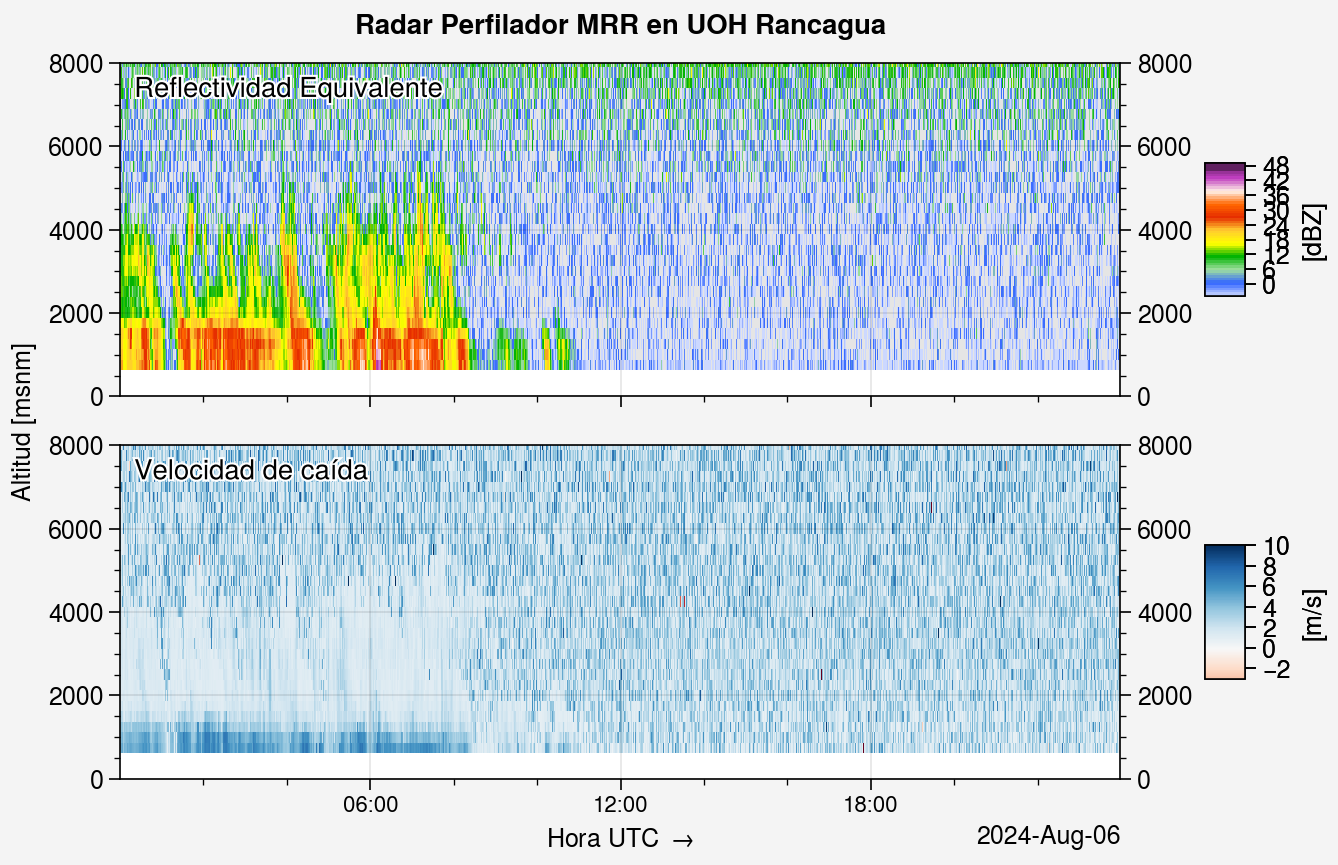

In [99]:
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0,:]+500
Ze = ds['attenuated_radar_reflectivity']
Vf = ds['fall_velocity']
# llamar a la funcion para plotear
plot_mrr2(xlim,pd.to_datetime(ds.time.values) , heights, Ze, Vf, hora_local=False)


## Filtro para ruido

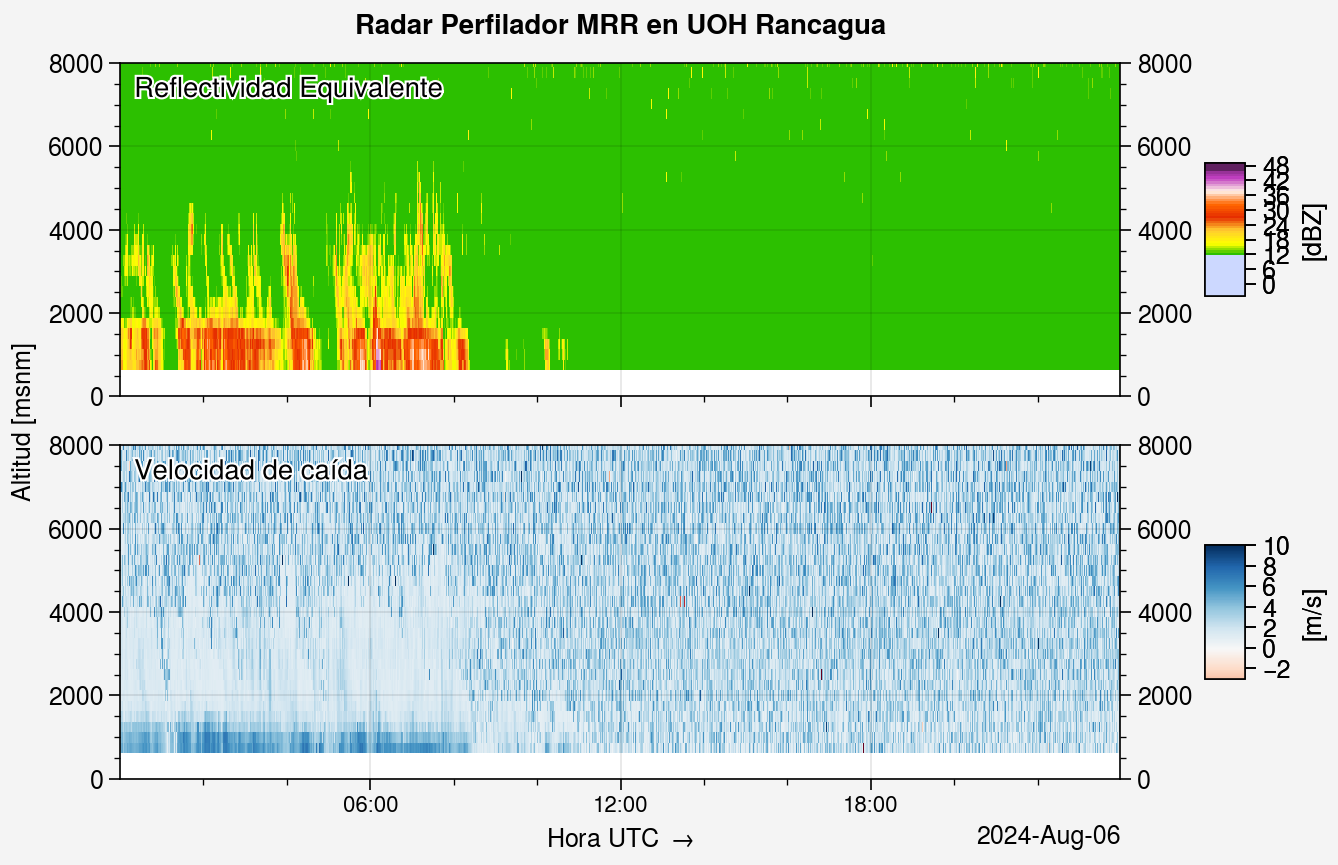

In [100]:
minimo= 12     # Valor minimo a filtrar
Ze_filtered = Ze.where(Ze >= minimo, minimo)


plot_mrr2(xlim,pd.to_datetime(ds.time.values) , heights, Ze_filtered, Vf, hora_local=False)

#hacer una nueva funcion con for que cambie ambos a la vez

## Funcion gradiente

In [101]:
import matplotlib.dates as mdates

In [102]:
def plot_mrr3(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex = paleta0):                   # aca cargar paleta de colores personalizada a usar
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops,colorhex):
            cmap4.append((value,color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom",cmap4)
    dbzmap.set_bad('0.9',1)
    bounds = np.arange(-5,50,1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
      xlabel = r'Hora Local $\rightarrow$'
    else:
      xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1]< 5000:
      ylim = [0, 3600]
    else:
      ylim = [0, 8000]

    total_seconds = (xlim[1]-xlim[0]).total_seconds()

    if total_seconds <= 14400:
      xlocator=('hour',range(0,24,1))
      xminorlocator=('minute',30)
    elif (total_seconds>14400) and (total_seconds<=82800.0):
      xlocator=('hour',range(0,24,3))
      xminorlocator=('hour',range(0,24,1))
    else:
      xlocator=('hour',range(0,24,6))
      xminorlocator=('hour',range(0,24,2))


    if Vf is None:

      if ax is None:
        fig, ax = pplt.subplots(refwidth=5, refaspect=3)

      mZe = ax.pcolormesh(times, heights, Ze,
                        norm=norm, cmap=dbzmap,
                        shading='auto', # permite que tickmark esté en centro de celda
                      #   extend='both'
                        )

      ax.format(	ultitle='Gradiente Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc=ytickloc,
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel,
                  )
      ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7,)

      if xlim != '':
          ax.format(xlim=xlim)

    else:

      fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

      mZe = ax[0].pcolormesh(times, heights, Ze,
                        norm=norm, cmap=dbzmap,
                        shading='auto', # permite que tickmark esté en centro de celda
                       #extend='both'
                        )
      add_no_data(ax[0], times, xlim)

      mVf = ax[1].pcolormesh(times, heights, Vf,
                            vmin=-3,vmax=10,        # Aca cambiar a la paleta de colores predeterminadas a usar
                             #cmap='Spectral',      # Colores paleta espectro visual
                             #cmap='RdYlGn',        # Colores paleta rojo-amarillo-verde
                             #cmap='RdYlBu',        # Colores paleta rojo-amarillo-azul
                             #cmap='RdGy',          # Colores paleta rojo-gris
                             cmap='RdBu',          # Colores paleta rojo-azul
                             #cmap='PuOr',           # Colores paleta purpura-naranja
                             #cmap='PRGn',          # Colores paleta purpura(rojiza)-verde(amarillento)
                             #cmap='PiYG',          # Colores paleta rosa-amarillo-verde
                             #cmap='BrBG',          # Colores paleta marron-azul(verdoso)
                            shading='auto',
                           #extend='both'
                            )
      add_no_data(ax[1], times, xlim)

      ax[0].format(	ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel,
                  )
      ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4,)

      ax[1].format(	ultitle='Velocidad de caída',
                      xrotation=False,
                      #   xformatter='%b-%d\n%H:%M',
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
          )
      ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4,
                    extend='both')

      if xlim != '':
          ax[0].format(xlim=xlim)
          ax[1].format(xlim=xlim)

    fig.show()

In [103]:
def plot_mrr3_imshow(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex = paleta0):
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops,colorhex):
        cmap4.append((value,color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom",cmap4)
    dbzmap.set_bad('0.9',1)
    bounds = np.arange(-5,50,1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
        xlabel = r'Hora Local $\rightarrow$'
    else:
        xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1]< 5000:
        ylim = [0, 3600]
    else:
        ylim = [0, 8000]

    total_seconds = (xlim[1]-xlim[0]).total_seconds()

    if total_seconds <= 14400:
        xlocator=('hour',range(0,24,1))
        xminorlocator=('minute',30)
    elif (total_seconds>14400) and (total_seconds<=82800.0):
        xlocator=('hour',range(0,24,3))
        xminorlocator=('hour',range(0,24,1))
    else:
        xlocator=('hour',range(0,24,6))
        xminorlocator=('hour',range(0,24,2))

    extent = [mdates.date2num(times[0]), mdates.date2num(times[-1]), heights[0], heights[-1]]

    if Vf is None:

        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.imshow(Ze, origin='lower', aspect='auto',
                        cmap=dbzmap, norm=norm,
                        extent=extent)

        ax.format(ultitle='Gradiente Reflectividad Equivalente',
                  xrotation=False,
                  xformatter='concise',
                  xlocator=xlocator,
                  xminorlocator=xminorlocator,
                  ylim=ylim,
                  yticklabelloc=ytickloc,
                  ytickloc='both',
                  xticklabelsize=8,
                  suptitle='Radar Perfilador MRR en UOH Rancagua',
                  ylabel='Altitud [msnm]',
                  xlabel=xlabel)

        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7)

        if xlim != '':
            ax.format(xlim=xlim)

    else:
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

        mZe = ax[0].imshow(Ze, origin='lower', aspect='auto',
                           cmap=dbzmap, norm=norm,
                           extent=extent)
        add_no_data(ax[0], times, xlim)

        mVf = ax[1].imshow(Vf, origin='lower', aspect='auto',
                           vmin=-3, vmax=10,
                           cmap='RdBu',
                           extent=extent)
        add_no_data(ax[1], times, xlim)

        ax[0].format(ultitle='Reflectividad Equivalente',
                     xrotation=False,
                     xformatter='concise',
                     xlocator=xlocator,
                     xminorlocator=xminorlocator,
                     ylim=ylim,
                     yticklabelloc='both',
                     ytickloc='both',
                     xticklabelsize=8,
                     suptitle='Radar Perfilador MRR en UOH Rancagua',
                     ylabel='Altitud [msnm]',
                     xlabel=xlabel)

        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4)

        ax[1].format(ultitle='Velocidad de caída',
                     xrotation=False,
                     xformatter='concise',
                     xlocator=xlocator,
                     xminorlocator=xminorlocator,
                     ylim=ylim,
                     yticklabelloc='both',
                     ytickloc='both',
                     xticklabelsize=8)

        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4,
                       extend='both')

        if xlim != '':
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

    fig.show()


In [104]:
def calcular_gradiente(datos, marco):
    pesos = np.array([marco - i for i in range(marco)])  
    pesos = pesos / np.sum(pesos)                        
    niveles_restantes = datos.shape[0] - 1 - 2 * (marco - 1)
    gradiente_datos = np.zeros((niveles_restantes, datos.shape[1]))

    for i in range(marco, datos.shape[0] - marco):
        superior = np.sum([pesos[j] * datos[i + j, :] for j in range(marco)], axis=0)
        inferior = np.sum([pesos[j] * datos[i - j - 1, :] for j in range(marco)], axis=0)
        gradiente_datos[i - marco, :] = superior - inferior

    filas_superior = marco
    filas_inferior = marco - 1

    gradiente_datos_completo = np.pad(gradiente_datos, ((filas_superior, filas_inferior), (0, 0)), mode='constant', constant_values=0)

    return gradiente_datos_completo

#mismo del jonathan

C:\Users\conym\AppData\Local\Temp\ipykernel_1192\445585250.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


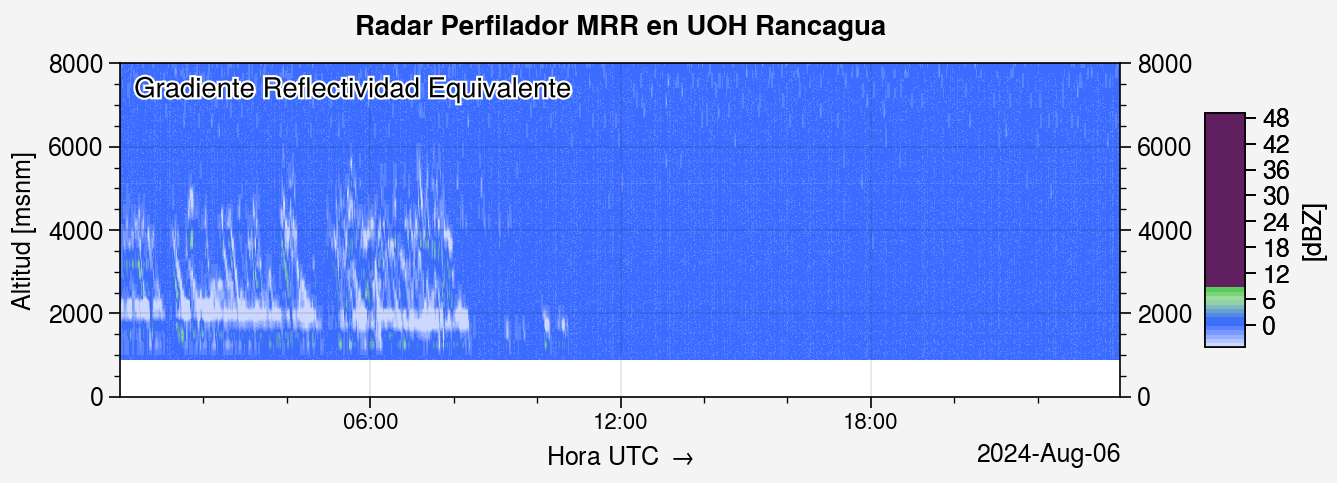

In [109]:
altura_inicial_desfase = 500 + (heights[1] - heights[0]) / 2   # Ajuste altura

heights_ajustado = ds.height[0, :] + altura_inicial_desfase

marco = 1
gradiente_Ze = calcular_gradiente(Ze_filtered.T, marco)
plot_mrr3_imshow(xlim, new_time, heights_ajustado, gradiente_Ze, hora_local=False)

# Funcion detectar isoterma

In [106]:
def detectar_isoterma_cero(gradiente, altura_inicial):
    resultados = []
    altura_actual = altura_inicial

    for t in range(gradiente.shape[1]):                      
        idx_altura = int((np.abs(heights_ajustado - altura_actual)).argmin()) # Ajuste altura ingresada con valor correspondiente
        gradiente_minimo = gradiente[idx_altura, t]
        altura_minima = heights_ajustado[idx_altura].values  
        idx_superior = max(idx_altura - 1, 0)
        idx_inferior = min(idx_altura + 1, len(heights_ajustado) - 1)

        for i in range(idx_superior, idx_inferior + 1):     
            if gradiente[i, t] < gradiente_minimo:
                gradiente_minimo = gradiente[i, t]
                altura_minima = heights_ajustado[i].values  
        
        altura_actual = altura_minima                      
        resultados.append({
            "iter": t,
            "altura_minima": altura_actual,
            "gradiente_minimo": gradiente_minimo
        })

    return resultados

C:\Users\conym\AppData\Local\Temp\ipykernel_1192\445585250.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


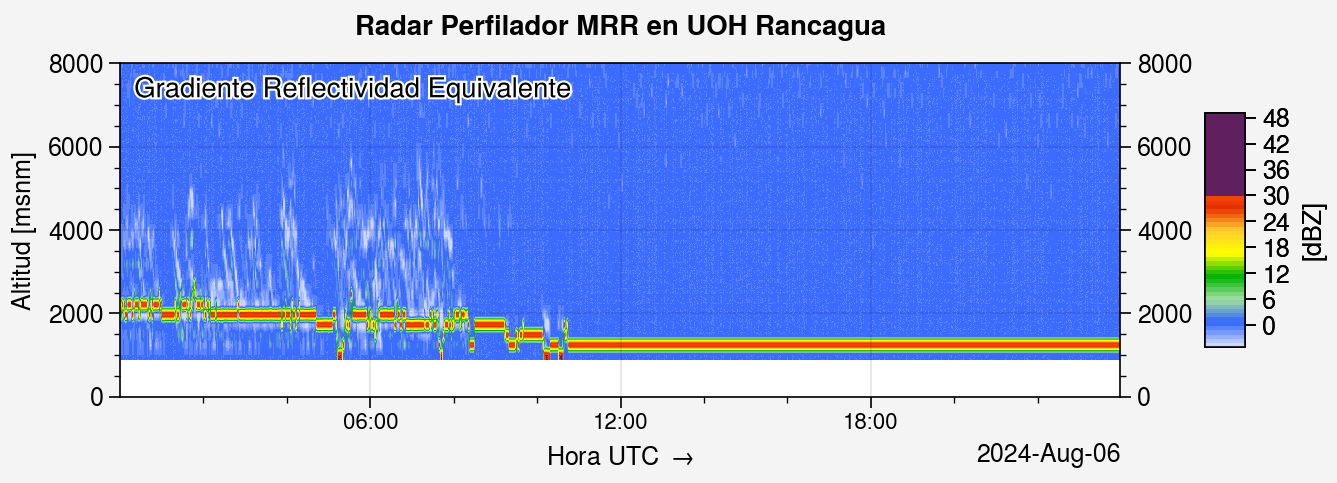

In [111]:
altura_inicial = 2000 
resultados_isoterma = detectar_isoterma_cero(gradiente_Ze, altura_inicial)
gradiente_modificado = np.copy(gradiente_Ze)
IndicesIsoterma = []
for resultado in resultados_isoterma:
    t = resultado["iter"]
    altura_minima = resultado["altura_minima"]
    idx_altura = int((np.abs(heights_ajustado - altura_minima)).argmin())
    IndicesIsoterma.append(idx_altura)
    gradiente_modificado[idx_altura, t] = 30

plot_mrr3_imshow(xlim, new_time, heights_ajustado, gradiente_modificado, hora_local=False)  
FactorConversion = (heights[-1].values-500)/ len(heights)
AlturasIsoterma = np.array(IndicesIsoterma) * FactorConversion 

## Funcion Filtro Kalman

In [ ]:
def filtro_kalman(alturas, delta_t, Q_ruido_proceso_reflectividad, Q_ruido_proceso_gradiente, R_ruido_medicion, factor_ponderador):
    
    f = KalmanFilter(dim_x=2, dim_z=1)
    f.x = np.array([alturas[0], 0])         # Estado inicial
    f.F = np.array([[1, delta_t], [0, 1]])  # Modelo de transición
    f.H = np.array([[1, 0]])                # Matriz de observación 
    f.P *= 0.1                              # Matriz de covarianza inicial
    f.R = R_ruido_medicion                  # Ruido de medición
    f.Q = np.array([[Q_ruido_proceso_reflectividad, 0], [0, Q_ruido_proceso_gradiente]])  # Ruido del proceso

    varianza_global = np.var(alturas)
    desviacion_global = np.sqrt(varianza_global)

    alturas_filtradas = []
    valores_confiables = [alturas[0]]

    for z in alturas[1:]:
        f.predict()
        media = np.mean(valores_confiables[-10:])  # Últimos 10 valores confiables
        limite_varianza_inferior = media - factor_ponderador * desviacion_global
        limite_varianza_superior = media + factor_ponderador * desviacion_global
        if limite_varianza_inferior <= z <= limite_varianza_superior:
            f.update(z)                   # Actualizar con el valor confiable
            valores_confiables.append(z)  # Agregar a la lista de confiables
        alturas_filtradas.append(f.x[0].copy())

    return np.array(alturas_filtradas)

In [ ]:
altura_inicial_desfase = 500 + (heights[1].values - heights[0].values) / 2
AlturasIsoterma_ajustadas = AlturasIsoterma + altura_inicial_desfase

# Parámetros del filtro Kalman
delta_t = 20                           # Intervalo de tiempo
Q_ruido_proceso_reflectividad = 1e-5   # Ruido del proceso para reflectividad
Q_ruido_proceso_gradiente = 1e-5       # Ruido del proceso para gradiente
R_ruido_medicion = 1                   # Ruido de medición
factor_ponderador = 0.65               # Ponderador para límites dinámicos(aca se modifica para ver la tolerancia del modelo)

alturas_filtradas = filtro_kalman(AlturasIsoterma_ajustadas, 
                                   delta_t, 
                                   Q_ruido_proceso_reflectividad, 
                                   Q_ruido_proceso_gradiente, 
                                   R_ruido_medicion, 
                                   factor_ponderador)

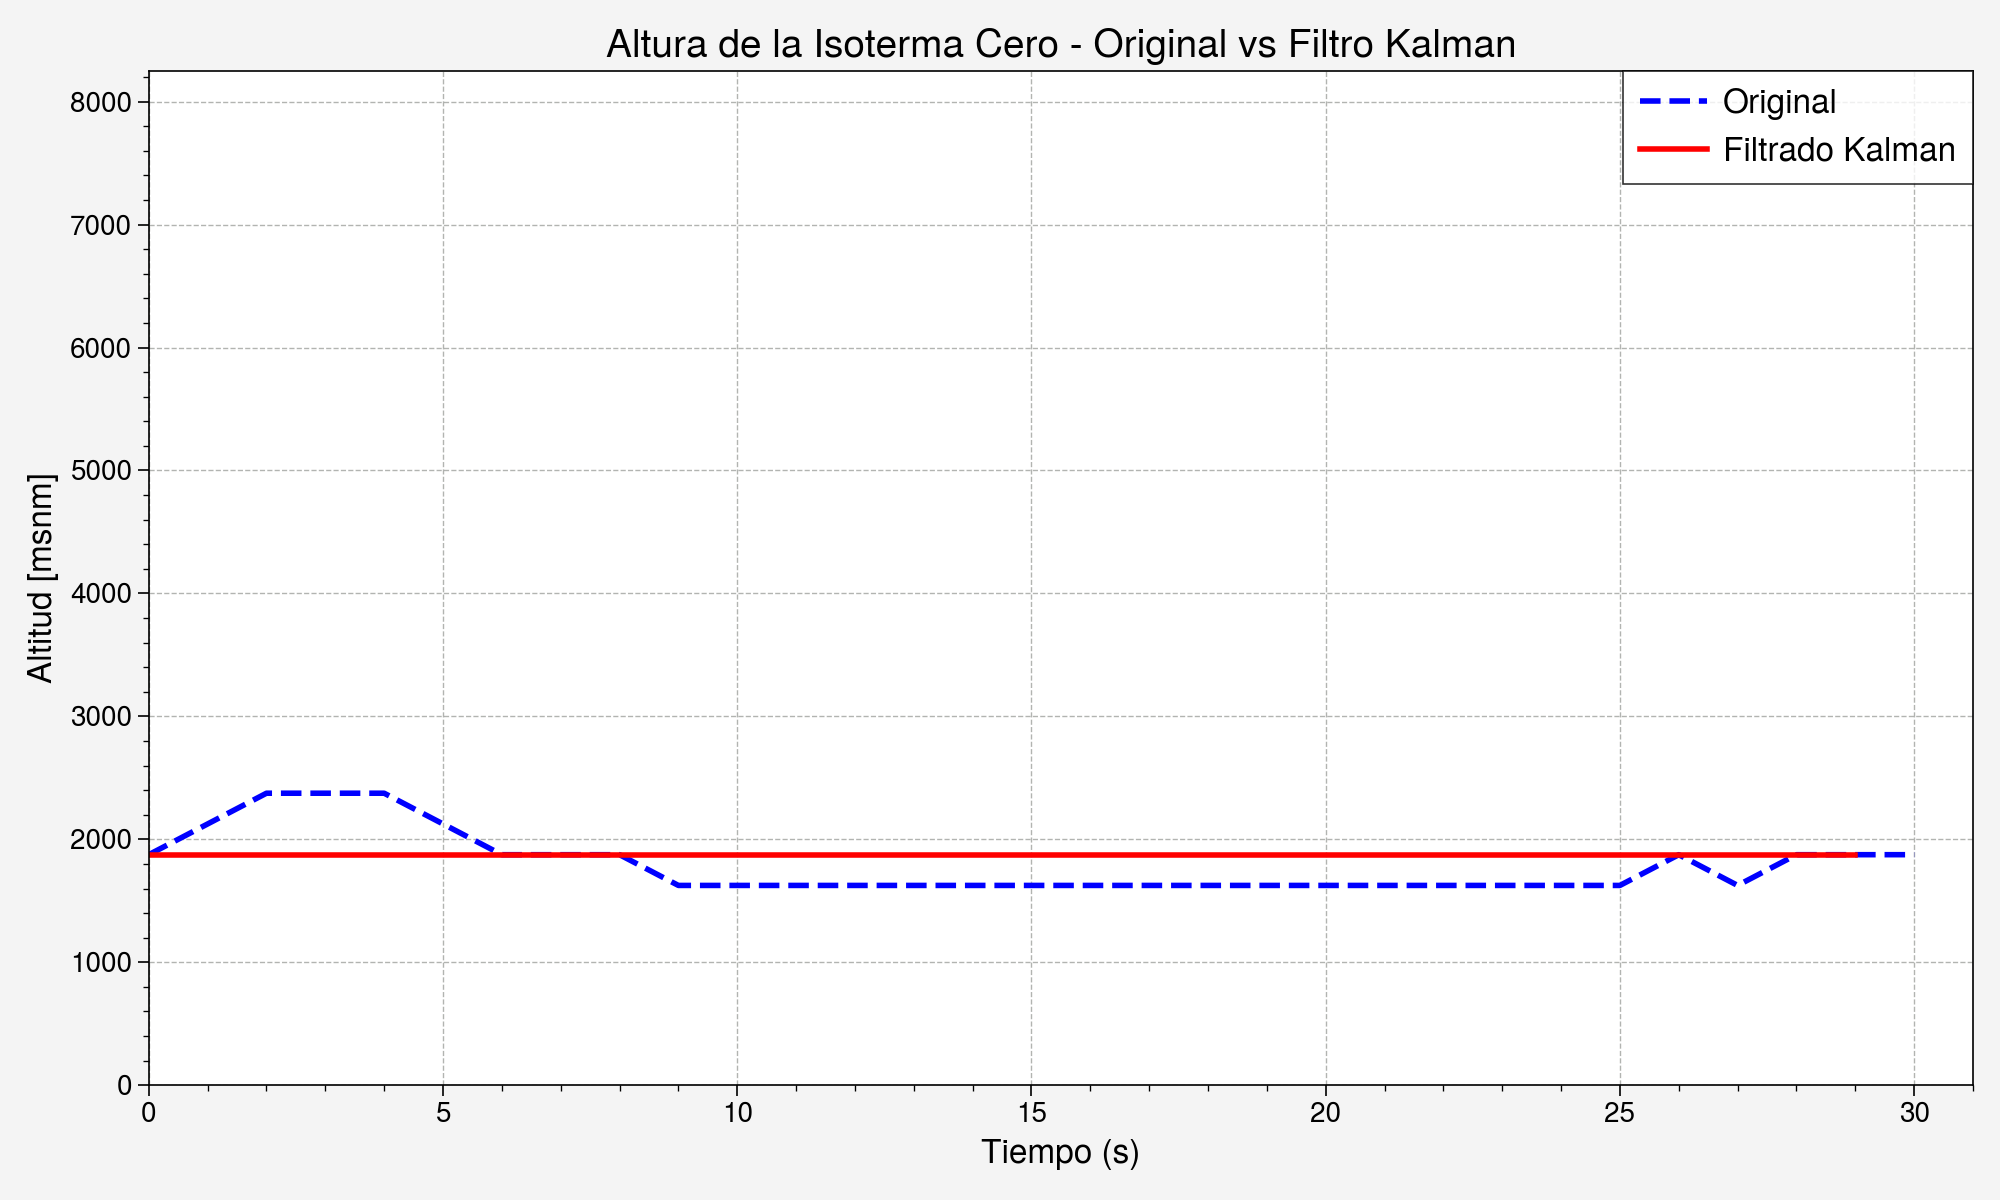

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))  
ax.plot(AlturasIsoterma_ajustadas, label="Original", linestyle='--', color='blue', linewidth=2)
ax.plot(alturas_filtradas, label="Filtrado Kalman", linestyle='-', color='red', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=12) 
ax.set_ylabel('Altitud [msnm]', fontsize=12)
ax.set_title('Altura de la Isoterma Cero - Original vs Filtro Kalman', fontsize=14)
ax.set_xlim([0, len(AlturasIsoterma)])  
ax.set_ylim([0, heights[-1].values])    
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()  
plt.show()

In [ ]:
def plot_mrr4(xlim, times, heights, Ze, Vf=None, isoterma=None, hora_local=False, ax=None,
              ytickloc='both', colorhex=paleta0):
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops, colorhex):
        cmap4.append((value, color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom", cmap4)
    dbzmap.set_bad('0.9', 1)
    bounds = np.arange(-5, 50, 1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
        xlabel = r'Hora Local $\rightarrow$'
    else:
        xlabel = r'Hora UTC $\rightarrow$'

    # Configurar límites de altura
    if heights[-1] < 5000:
        ylim = [0, 3600]
    else:
        ylim = [0, 8000]

    total_seconds = (xlim[1] - xlim[0]).total_seconds()
    if total_seconds <= 14400:
        xlocator = ('hour', range(0, 24, 1))
        xminorlocator = ('minute', 30)
    elif (total_seconds > 14400) and (total_seconds <= 82800.0):
        xlocator = ('hour', range(0, 24, 3))
        xminorlocator = ('hour', range(0, 24, 1))
    else:
        xlocator = ('hour', range(0, 24, 6))
        xminorlocator = ('hour', range(0, 24, 2))

    if Vf is None:
        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.pcolormesh(times, heights, Ze,  
                            norm=norm, cmap=dbzmap, 
                            shading='auto')

        if isoterma is not None:
            ax.plot(times, isoterma, color='black', linestyle='--', linewidth=1.5, label='Isoterma (Filtrada)')
            ax.legend()  # Mostrar leyenda

        ax.format(ultitle='Reflectividad Equivalente',
                  xrotation=False,
                  xformatter='concise',
                  xlocator=xlocator,
                  xminorlocator=xminorlocator,
                  ylim=ylim,
                  yticklabelloc=ytickloc,
                  ytickloc='both',
                  xticklabelsize=8,
                  suptitle='Radar Perfilador MRR en UOH Rancagua',
                  ylabel='Altitud [msnm]',
                  xlabel=xlabel)
        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7,)

        if xlim != '':
            ax.format(xlim=xlim)

    else:
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

        mZe = ax[0].pcolormesh(times, heights, Ze,  
                               norm=norm, cmap=dbzmap, 
                               shading='auto')
        add_no_data(ax[0], times, xlim)

        mVf = ax[1].pcolormesh(times, heights, Vf, 
                               vmin=-3, vmax=10, cmap='RdBu', shading='auto')
        add_no_data(ax[1], times, xlim)

        if isoterma is not None:
            ax[0].plot(times, isoterma, color='black', linestyle='--', linewidth=1.5, label='Isoterma (Filtrada)')
            ax[0].legend()  # Mostrar leyenda

        ax[0].format(ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel)
        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4,)

        ax[1].format(ultitle='Velocidad de caída',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8)
        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, extend='both')

        if xlim != '':
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

    fig.show()



ValueError: x and y must have same first dimension, but have shapes (2386,) and (31,)

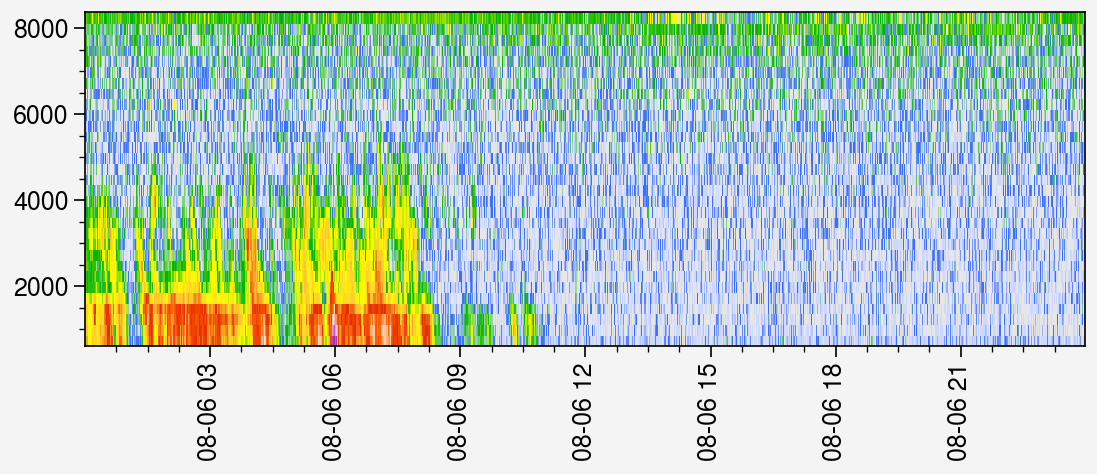

In [ ]:
# Grafico solo de reflectividad
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0, :].values + 500  
Ze = ds['attenuated_radar_reflectivity'].T.values  

# Ajustar alturas_filtradas para que coincida con times
if len(alturas_filtradas) < len(new_time):
    alturas_filtradas = np.append([alturas_filtradas[0]], alturas_filtradas)
elif len(alturas_filtradas) > len(new_time):
    alturas_filtradas = alturas_filtradas[:len(new_time)]


plot_mrr4(
    xlim=xlim,
    times=new_time,
    heights=heights,
    Ze=Ze,
    isoterma=alturas_filtradas,  # Línea de isoterma filtrada
    hora_local=False
)

In [ ]:
def plot_mrr4(xlim, times, heights, Ze, Vf=None, isoterma=None, hora_local=False, ax=None,
              ytickloc='both', colorhex=paleta0):
    cmap4 = []
    stops = [0, 1./10, 2./10, 3./10, 4./10, 5./10, 6./10, 7./10, 8./10, 9./10, 1]
    for value, color in zip(stops, colorhex):
        cmap4.append((value, color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom", cmap4)
    dbzmap.set_bad('0.9', 1)
    bounds = np.arange(-5, 50, 1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)
    
    if hora_local:
        xlabel = r'Hora Local $\rightarrow$'
    else:
        xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1] < 5000:
        ylim = [0, 3600]
    else:
        ylim = [0, 8000]

    total_seconds = (xlim[1] - xlim[0]).total_seconds()
    if total_seconds <= 14400:
        xlocator = ('hour', range(0, 24, 1))
        xminorlocator = ('minute', 30)
    elif (total_seconds > 14400) and (total_seconds <= 82800.0):
        xlocator = ('hour', range(0, 24, 3))
        xminorlocator = ('hour', range(0, 24, 1))
    else:
        xlocator = ('hour', range(0, 24, 6))
        xminorlocator = ('hour', range(0, 24, 2))

    if Vf is not None:
        fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

        mZe = ax[0].pcolormesh(times, heights, Ze,
                               norm=norm, cmap=dbzmap,
                               shading='auto')
        add_no_data(ax[0], times, xlim)

        mVf = ax[1].pcolormesh(times, heights, Vf,
                               vmin=-3, vmax=10, cmap='RdBu', shading='auto')
        add_no_data(ax[1], times, xlim)

        # Agregar línea de la isoterma en ambos gráficos
        if isoterma is not None:
            ax[0].plot(times, isoterma, color='black', linestyle='--', linewidth=1.5, label='Isoterma Cero')
            ax[1].plot(times, isoterma, color='black', linestyle='--', linewidth=1.5, label='Isoterma Cero')
            ax[0].legend(loc='upper right', fontsize=10)  
            ax[1].legend(loc='upper right', fontsize=10)  
            

        ax[0].format(ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel)
        ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4,)

        ax[1].format(ultitle='Velocidad de caída',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8)
        ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, extend='both')

        if xlim != '':
            ax[0].format(xlim=xlim)
            ax[1].format(xlim=xlim)

    else:
        if ax is None:
            fig, ax = pplt.subplots(refwidth=5, refaspect=3)

        mZe = ax.pcolormesh(times, heights, Ze,
                            norm=norm, cmap=dbzmap,
                            shading='auto')

        ax.format(ultitle='Reflectividad Equivalente',
                  xrotation=False,
                  xformatter='concise',
                  xlocator=xlocator,
                  xminorlocator=xminorlocator,
                  ylim=ylim,
                  yticklabelloc=ytickloc,
                  ytickloc='both',
                  xticklabelsize=8,
                  suptitle='Radar Perfilador MRR en UOH Rancagua',
                  ylabel='Altitud [msnm]',
                  xlabel=xlabel)
        ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7,)

        if xlim != '':
            ax.format(xlim=xlim)

    fig.show()


c:\Users\conym\anaconda3\envs\proyecto\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
c:\Users\conym\anaconda3\envs\proyecto\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)


ValueError: x and y must have same first dimension, but have shapes (2386,) and (32,)

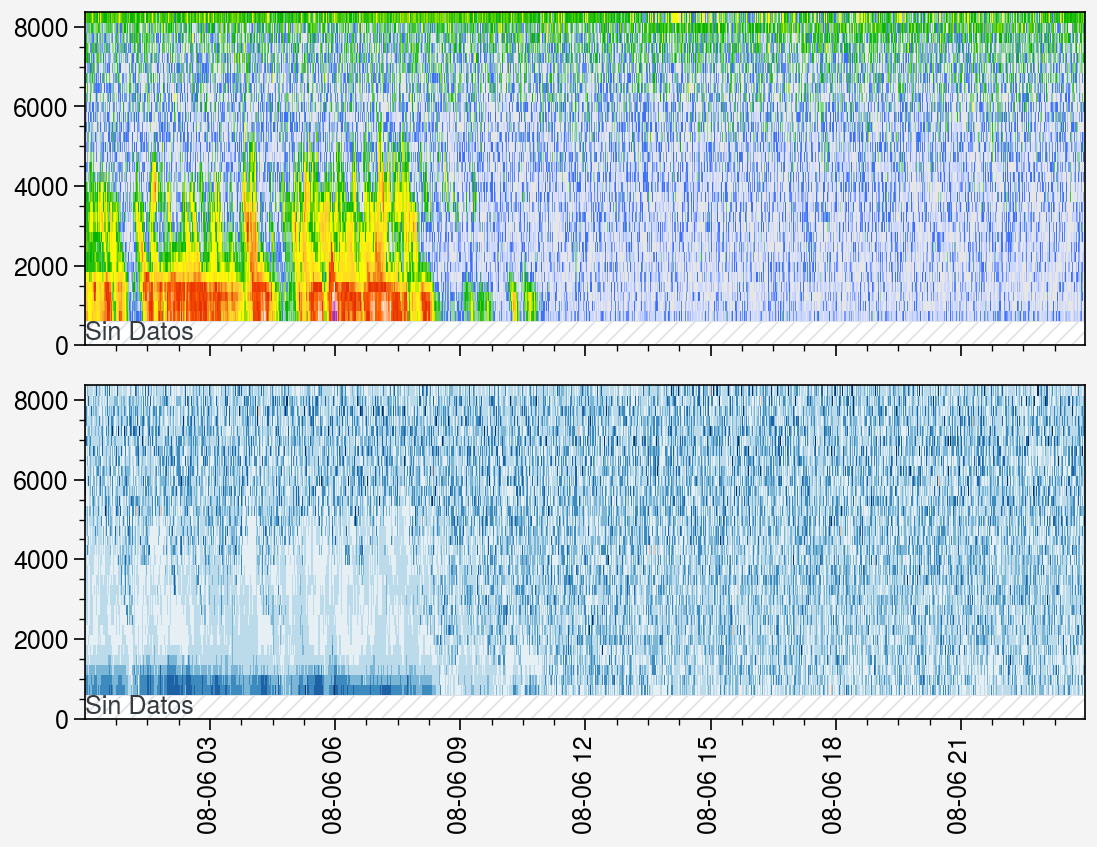

In [ ]:
plot_mrr4(
    xlim=[new_time[0], new_time[-1]],                 # Límites de tiempo
    times=new_time,                                   # Eje temporal
    heights=ds.height[0, :].values + 500,             # Alturas ajustadas
    Ze=ds['attenuated_radar_reflectivity'].T.values,  # Reflectividad
    Vf=ds['fall_velocity'].T.values,                  # Velocidad de caída
    isoterma=alturas_filtradas,                       # Línea de isoterma filtrada
    hora_local=False
) 